# Let's start with our crazy stock list of imports and setup our environment

In [1]:
# See requirements.txt to set up your dev environment.
import os
import sys
import utm
import json
import scipy
import overpy
import urllib
import datetime 
import urllib3
import rasterio
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from osgeo import gdal
from planet import api
from planet.api import filters
from traitlets import link
import rasterio.tools.mask as rio_mask
from shapely.geometry import mapping, shape
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from scipy import ndimage
import warnings
from osgeo import gdal
from osmapi import OsmApi
#http://python-overpy.readthedocs.io/en/latest/introduction.html
# http://overpass-turbo.eu/# <- construct nice queries
from geopy.geocoders import Nominatim
# GDAL does not use python exceptions by default


urllib3.disable_warnings()
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

%matplotlib inline
# will pick up api_key via environment variable PL_API_KEY
# but can be specified using `api_key` named argument
api_keys = json.load(open("apikeys.json",'r'))
client = api.ClientV1(api_key=api_keys["PLANET_API_KEY"])
gdal.UseExceptions()
api = overpy.Overpass()

In [2]:
#run this to get something we can render or use the visual product
#gdal_translate -ot Byte -scale 0 4096 0 255 /home/kat/code/hacking/osm/20170222_231253_0c27/20170222_231253_0c27_3B_AnalyticMS.tif test.tif

# Let's bring up our slippy map once again.

In [3]:
# Basemap Mosaic (v1 API)
mosaicsSeries = 'global_quarterly_2017q1_mosaic'
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaicsTilesURL_base = 'https://tiles0.planet.com/experimental/mosaics/planet-tiles/' + mosaicsSeries + '/gmap/{z}/{x}/{y}.png'
# Planet tile server url
mosaicsTilesURL = mosaicsTilesURL_base + '?api_key=' + api_keys["PLANET_API_KEY"]
# Map Settings 
# Define colors
colors = {'blue': "#009da5"}
# Define initial map center lat/long
center = [45.5231, -122.6765]
# Define initial map zoom level
zoom = 13
# Set Map Tiles URL
planetMapTiles = TileLayer(url= mosaicsTilesURL)
# Create the map
m = Map(
    center=center, 
    zoom=zoom,
    default_tiles = planetMapTiles # Uncomment to use Planet.com basemap
)
# Define the draw tool type options
polygon = {'shapeOptions': {'color': colors['blue']}}
rectangle = {'shapeOptions': {'color': colors['blue']}} 

# Create the draw controls
# @see https://github.com/ellisonbg/ipyleaflet/blob/master/ipyleaflet/leaflet.py#L293
dc = DrawControl(
    polygon = polygon,
    rectangle = rectangle
)
# Initialize an action counter variable
actionCount = 0
AOIs = {}

# Register the draw controls handler
def handle_draw(self, action, geo_json):
    # Increment the action counter
    global actionCount
    actionCount += 1
    # Remove the `style` property from the GeoJSON
    geo_json['properties'] = {}
    # Convert geo_json output to a string and prettify (indent & replace ' with ")
    geojsonStr = json.dumps(geo_json, indent=2).replace("'", '"')
    AOIs[actionCount] = json.loads(geojsonStr)
    
# Attach the draw handler to the draw controls `on_draw` event
dc.on_draw(handle_draw)
m.add_control(dc)
m

# Let's review from last time. 
* We'll query the Planet API and get a list of scenes.
* We'll then use pandas and shapely to clean up and filter the results
* We'll then render the footprints of the good scenes over our AOI

In [4]:
print AOIs[1]
myAOI = AOIs[1]["geometry"]

# build a query using the AOI and
# a cloud_cover filter that excludes 'cloud free' scenes

old = datetime.datetime(year=2013,month=1,day=1)

query = filters.and_filter(
    filters.geom_filter(myAOI),
    filters.range_filter('cloud_cover', lt=50),
    filters.date_range('acquired', gt=old)
)

# build a request for only PlanetScope imagery
request = filters.build_search_request(
    query, item_types=['PSScene3Band']
)

# if you don't have an API key configured, this will raise an exception
result = client.quick_search(request)
scenes = []
planet_map = {}
for item in result.items_iter(limit=500):
    planet_map[item['id']]=item
    props = item['properties']
    props["id"] = item['id']
    props["geometry"] = item["geometry"]
    props["thumbnail"] = item["_links"]["thumbnail"]
    scenes.append(props)
scenes = pd.DataFrame(data=scenes)
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])

scenes = scenes[scenes['overlap']>0.9]


print len(scenes)
# now let's clean up the datetime stuff
# make a shapely shape from our aoi
portland = shape(myAOI)
footprints = []
overlaps = []
# go through the geometry from our api call, convert to a shape and calculate overlap area.
# also save the shape for safe keeping
for footprint in scenes["geometry"].tolist():
    s = shape(footprint)
    footprints.append(s)
    overlap = 100.0*(portland.intersection(s).area / portland.area)
    overlaps.append(overlap)
# take our lists and add them back to our dataframe
scenes['overlap'] = pd.Series(overlaps, index=scenes.index)
scenes['footprint'] = pd.Series(footprints, index=scenes.index)
# now make sure pandas knows about our date/time columns.
scenes["acquired"] = pd.to_datetime(scenes["acquired"])
scenes["published"] = pd.to_datetime(scenes["published"])
scenes["updated"] = pd.to_datetime(scenes["updated"])

# first create a list of colors
colors = ["#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff"]
# grab our scenes from the geometry/footprint geojson
footprints = scenes["geometry"].tolist()
# for each footprint/color combo

for footprint,color in zip(footprints,colors):
    # create the leaflet object
    feat = {'geometry':footprint,"properties":{
            'style':{'color': color,'fillColor': color,'fillOpacity': 0.1,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
# now we will draw our original AOI on top 
feat = {'geometry':myAOI,"properties":{
            'style':{'color': "#FFFFFF",'fillColor': "#FFFFFF",'fillOpacity': 0.1,'weight': 2}},
            'type':u"Feature"}
gjson = GeoJSON(data=feat)
m.add_layer(gjson)   
m 

{u'geometry': {u'type': u'Polygon', u'coordinates': [[[-122.69142151577398, 45.479266648328405], [-122.69142151577398, 45.569707186438215], [-122.5712585519068, 45.569707186438215], [-122.5712585519068, 45.479266648328405], [-122.69142151577398, 45.479266648328405]]]}, u'type': u'Feature', u'properties': {}}


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:334: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


150


# Now we'll add in our boiler plate activation code for reference.

In [5]:
def get_products(client, scene_id, asset_type='PSScene3Band'):    
    """
    Ask the client to return the available products for a 
    given scene and asset type. Returns a list of product 
    strings
    """
    out = client.get_assets_by_id(asset_type,scene_id)
    temp = out.get()
    return temp.keys()

def activate_product(client, scene_id, asset_type="PSScene3Band",product="analytic"):
    """
    Activate a product given a scene, an asset type, and a product.
    
    On success return the return value of the API call and an activation object
    """
    temp = client.get_assets_by_id(asset_type,scene_id)  
    products = temp.get()
    if( product in products.keys() ):
        return client.activate(products[product]),products[product]
    else:
        return None 

def download_and_save(client,product):
    """
    Given a client and a product activation object download the asset. 
    This will save the tiff file in the local directory and return its 
    file name. 
    """
    out = client.download(product)
    fp = out.get_body()
    fp.write()
    return fp.name

def scenes_are_active(scene_list):
    """
    Check if all of the resources in a given list of
    scene activation objects is read for downloading.
    """
    retVal = True
    for scene in scene_list:
        if scene["status"] != "active":
            print "{} is not ready.".format(scene)
            return False
    return True

# Now we'll activate our scenes

In [6]:
to_get = scenes["id"][0:6].tolist()
activated = []
# for each scene to get
for scene in to_get:
    # get the product 
    product_types = get_products(client,scene)
    for p in product_types:
        # if there is a visual product
        if p == "visual": # p == "basic_analytic_dn"
            print "Activating {0} for scene {1}".format(p,scene)
            # activate the product
            _,product = activate_product(client,scene,product=p)
            activated.append(product)

Activating visual for scene 20170510_182150_0e1f
Activating visual for scene 20170510_182151_0e1f
Activating visual for scene 20170506_181536_1034
Activating visual for scene 20170506_181534_1034
Activating visual for scene 20170506_181535_1034
Activating visual for scene 20170503_181521_0f35


# And then download them.

In [76]:
tiff_files = []
asset_type = "_3B_Visual"
# check if our scenes have been activated
if True:#scenes_are_active(activated):
    for to_download,name in zip(activated,to_get):
        # create the product name
        name = name + asset_type + ".tif"
        # if the product exists locally
        if( os.path.isfile(name) ):
            # do nothing 
            print "We have scene {0} already, skipping...".format(name)
            tiff_files.append(name)
        elif to_download["status"] == "active":
            # otherwise download the product
            print "Downloading {0}....".format(name)
            fname = download_and_save(client,to_download)
            tiff_files.append(fname)
            print "Download done."
        else:
            print "Could not download, still activating"
else:
    print "Scenes aren't ready yet"

print tiff_files 

We have scene 20170510_182150_0e1f_3B_Visual.tif already, skipping...
We have scene 20170510_182151_0e1f_3B_Visual.tif already, skipping...
Could not download, still activating
Could not download, still activating
Could not download, still activating
Could not download, still activating
[u'20170510_182150_0e1f_3B_Visual.tif', u'20170510_182151_0e1f_3B_Visual.tif']


# Let's get going with Open Street Maps.
* [Open Street Maps](https://www.openstreetmap.org/) is a huge and open collection of data about the earth. 
* OSM is free to query. The interfaces are powerful, but hella cryptic. 
* Let's say we had a pixel in an image and we wanted to know what in the world was at that pixel. 
* We can use the Open Street Maps [Nominatim](http://wiki.openstreetmap.org/wiki/Nominatim) function to look up what is there, like google maps.
* We can also use the OSM interface to find the 'nodes' near our pixel. 
* OSM Nominatim works through Lat Long values. To get these lat long values we are going to through [UTM coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system).
* To get correct the UTM values we'll need to ask GDAL what our UDM zone is.

In [78]:
infile = "20170510_182150_0e1f_3B_Visual.tif" #tiff_files[0]
# Open the file
gtif = gdal.Open(infile)
# Get the project reference object this knows the UTM zone
reff = gtif.GetProjectionRef()
# arr is the actual image data.
arr = gtif.ReadAsArray()
# Trans is our geo transfrom array. 
trans = gtif.GetGeoTransform()
# print the ref object
print reff
# find our UTM zone
i = reff.find("UTM")
print reff[i:i+12]

PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]
UTM zone 10N


# Now we are going to write a function to convert pixels to UTM
* Also a quick function to plot a point

In [79]:
def pixel2utm(ds, x, y):
    """
    Returns utm coordinates from pixel x, y coords
    """
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)

def draw_point(x,y,img):
    t = 20
    img[y-t:y+t,x-t:x+t,:] = [255,0,0]

# Now let's query a point on our scene and see what OSM tells us.
* First we'll define a pixel position
* We'll use GDAL to open the scene and then map a pixel to UTM
* We'll then convert the UTM value to Lat / Lon using the UTM region we found before. 
* Then we'll instantiate a Nominatim object and perform a revers lookup and print the results. 
* We'll then use the OSM Api to get node at this place. 

In [80]:
pos = [8000,3000] # this is the pixel we want info abou
ds = gdal.Open(infile)
# take the GDAL info and make it into UTM
my_utm = pixel2utm(ds,pos[0],pos[1])
# convert UTM into Lat Long
# need to figure out how to get zone info
my_lla = utm.to_latlon(my_utm[0],my_utm[1],10,"N")
# do the lat long look up from OSM
geolocator = Nominatim()
# reverse look up the are based on lat lon
location = geolocator.reverse("{0},{1}".format(my_lla[0],my_lla[1]))
# print location info
print location.address
print location.raw
# get the OSM ID info
osm_id = int(location.raw["place_id"])
print osm_id
# create an interface to the OSM API
MyApi = OsmApi()
# Look up our position 
print MyApi.NodeGet(osm_id)


Northeast Shaver Street, Parkrose, Portland, Multnomah County, Oregon, 97220, United States of America
{u'display_name': u'Northeast Shaver Street, Parkrose, Portland, Multnomah County, Oregon, 97220, United States of America', u'place_id': u'110159740', u'lon': u'-122.5403422', u'boundingbox': [u'45.5516887', u'45.5517621', u'-122.5424089', u'-122.5381576'], u'osm_type': u'way', u'licence': u'Data \xa9 OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', u'osm_id': u'197463713', u'lat': u'45.5517604', u'address': {u'city': u'Portland', u'country': u'United States of America', u'county': u'Multnomah County', u'suburb': u'Parkrose', u'state': u'Oregon', u'postcode': u'97220', u'country_code': u'us', u'road': u'Northeast Shaver Street'}}
110159740


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:132: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning


{u'changeset': 5823468, u'uid': 28805, u'timestamp': datetime.datetime(2010, 9, 19, 19, 35, 31), u'lon': -75.3307754, u'visible': True, u'version': 3, u'user': u'Matthew Truch', u'lat': 39.9719526, u'tag': {}, u'id': 110159740}


# Now for completeness we'll plot our scene and add the annotation about the spot we found. 

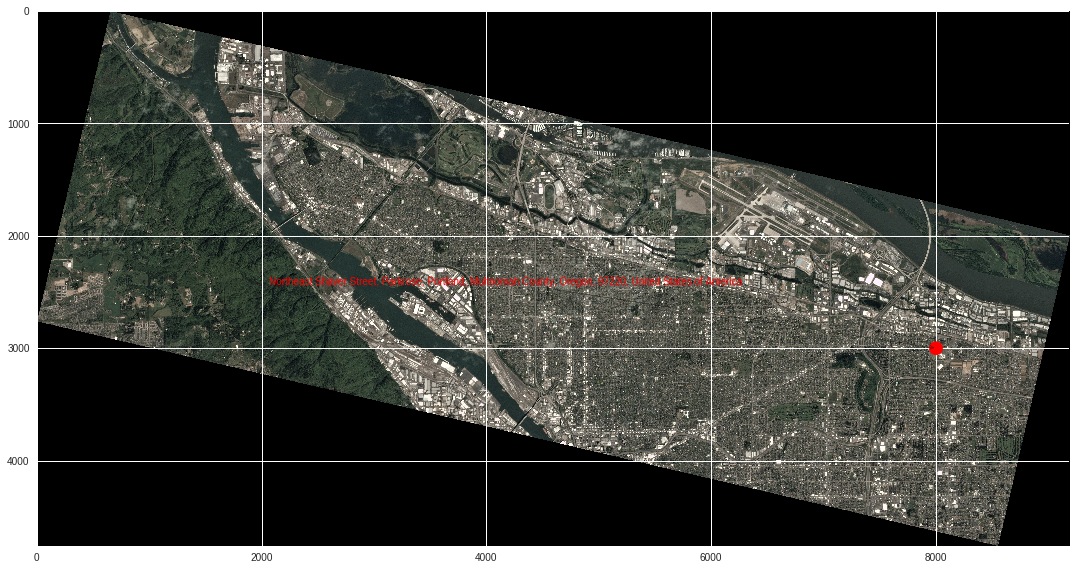

In [82]:
from matplotlib.patches import Circle
fig,ax = plt.subplots(1)

# create our plot
plt.imshow(arr[:3,:,:].transpose((1, 2, 0)))#, extent=extent)
fig = plt.gcf()
# add our annotation
plt.annotate(location.address, xy=pos, xycoords='data',
             xytext=(0.25, 0.5), textcoords='figure fraction',color="red",
             arrowprops=dict(arrowstyle="->"))
ax.set_aspect('equal')
# Set a point
circ = Circle((pos[0],pos[1]),60,color="red")
ax.add_patch(circ)
fig.set_size_inches(18.5, 10.5)
plt.show()

# Now, well, OSM is hard.
* This is I wanted to show where to programaticalyy query OSM for all sorts of data.
* Turns out that it is a lot harder than it should be, especially if you want to work with GeoJson.
* Out of scope for this talk, but let's punt.
* OSM has a feature called Overdpass. It is like the most convoluted Google maps ever using a very complex query language that I still don't grok. 
* We're going to use it to get all of the parks in Portland as GeoJSON using the web interface called Overpass Turbo.
* [Let's take a look at that.](https://overpass-turbo.eu/)
* Here's the query to run. Then export as GeoJSON
```
[bbox:{{bbox}}][timeout:1800];
way["leisure"="park"];map_to_area->.a;
foreach(
  (._;>;);
  is_in;
  way(pivot)["leisure"="park"];
  out geom;
);
```

In [117]:
import geopandas as gpd
fname = "./portland_parks_small.geojson"
park_df = gpd.read_file(fname)
portland_parks = json.load(open(fname,'r'))
geojson = [p for p in portland_parks["features"]]
p = [p.area for p in park_df["geometry"].tolist()]
park_df["area"] = pd.Series(p)
park_df["geojson"] = pd.Series(geojson)
park_df.sort(['area',], ascending=[1])
park_df.head()
#print park_df["wikipedia"].dropna()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,@id,RLIS:park_id,access,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,alt_name,area,...,phone,source,surface,tourism,website,wheelchair,wikidata,wikipedia,world_record,geojson
0,way/67729219,None,None,None,None,None,OR,None,None,5.085001e-06,...,None,None,None,None,None,None,None,None,None,"{u'geometry': {u'type': u'Polygon', u'coordina..."
1,way/318093532,None,None,None,None,None,OR,None,None,1.777100e-05,...,None,None,None,None,None,None,None,None,None,"{u'geometry': {u'type': u'Polygon', u'coordina..."
2,way/129888425,None,None,None,None,None,OR,None,None,2.702643e-06,...,None,None,None,None,None,None,None,None,None,"{u'geometry': {u'type': u'Polygon', u'coordina..."
3,way/129888427,None,None,None,None,None,OR,None,None,3.810489e-06,...,None,None,None,None,None,None,None,None,None,"{u'geometry': {u'type': u'Polygon', u'coordina..."
4,way/130683262,None,None,None,None,None,OR,None,None,5.519825e-07,...,None,None,None,None,None,None,None,None,None,"{u'geometry': {u'type': u'Polygon', u'coordina..."


In [50]:
portland_parks = json.load(open("portland_parks_small.geojson",'r'))
for p in portland_parks["features"]:
    feat = {'geometry':p["geometry"],"properties":{
            'style':{'color': "#00FF00",'fillColor': "#00FF00",'fillOpacity': 0.8,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
m

In [115]:
temp = park_df[park_df["name"]=="Grant Park"]
i = 0
for p in portland_parks["features"]:
    if p["properties"]["name"] == "Grant Park":
        print "ASDFASDFAS"
        with open("test{0}.geojson".format(i),'w') as fp:
            fp.write(json.dumps(p))
        i+=1
#with open("tester.wkt".format(i),'w') as fp:
#    fp.write(temp["geometry"].tolist()[1].wkt)
# gdalwarp -t_srs EPSG:3857 -cutline tester.wkt -crop_to_cutline -tap -tr 3 3 -overwrite 20170510_182150_0e1f_3B_Visual.tif result.tif


#for i in range(0,5):
#    print park_df["name"][i]
#    geo = park_df["geometry"][i]
#    with open("test{0}.wkt".format(i),'w') as fp:
#        fp.write(geo.wkt)
#    print geo.wkt
# gdal_warp
#commands = ["gdalwarp", # t
#           "-t_srs","EPSG:3857",
#           "-cutline",aoi_file,
#           "-crop_to_cutline",
#           "-tap",
#            "-tr", "3", "3"
#           "-overwrite"]
#output_mosaic = "merged.tif"

ASDFASDFAS


In [51]:
portland_parks = json.load(open("portland_parks_small.geojson",'r'))
parks = []#pd.DataFrame()
for p in portland_parks["features"]:
    temp = {}
    temp["name"]= p["properties"]["name"]
    temp["geom"] = p["geometry"]
    temp["shape"] = shape(geom)
    park_by_name[name]["shape"] = s
    print "{0} - {1}".format(name,s.area)
    feat = {'geometry':geom,"properties":{
            'style':{'color': "#00FF00",'fillColor': "#00FF00",'fillOpacity': 1,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
m

Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickitat Mall - 5.08500118e-06
Klickita

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
portland_parks = json.load(open("portland_parks_small.geojson",'r'))

# first create a list of colors
colors = ["#ff0000","#00ff00","#0000ff","#ffff00","#ff00ff","#00ffff"]
# grab our scenes from the geometry/footprint geojson
footprints = scenes["geometry"].tolist()
# for each footprint/color combo

for footprint,color in zip(footprints,colors):
    # create the leaflet object
    feat = {'geometry':footprint,"properties":{
            'style':{'color': color,'fillColor': color,'fillOpacity': 0.1,'weight': 1}},
            'type':u"Feature"}
    # convert to geojson
    gjson = GeoJSON(data=feat)
    # add it our map
    m.add_layer(gjson)
# now we will draw our original AOI on top 
feat = {'geometry':myAOI,"properties":{
            'style':{'color': "#FFFFFF",'fillColor': "#FFFFFF",'fillOpacity': 0.1,'weight': 2}},
            'type':u"Feature"}
gjson = GeoJSON(data=feat)
m.add_layer(gjson)   
m 

# Now let's see which of these parks intersect with our scene
* We'll open our GeoJSON file and convert the GeoJSON to shapely shapes.
* We'll also 

In [ ]:
def get_osm_data(lat,lon):
    retVal = {}
    geolocator = Nominatim()
    MyApi = OsmApi()
    location = geolocator.reverse("{0},{1}".format(lat,lon))
    retVal["address"] = location.address
    retVal["id"] = location.raw["place_id"]
    # get the OSM ID info
    #osm_id = int()
    #print osm_id
    # create an interface to the OSM API
    # Look up our position 
    #print MyApi.NodeGet(osm_id)
    return retVal
    
print AOIs[1]
myAOI = AOIs[1]["geometry"]
for pt in myAOI['coordinates']:
    # reverse look up the are based on lat lon
    temp = get_osm_data(pt[1],pt[0])
    print temp["address"]

In [ ]:
#https://michelleful.github.io/code-blog/2015/04/27/osm-data/

In [ ]:
# https://github.com/jwass/geopandas_osm
# THIS IS THE SHIT! 
import json
import shapely.geometry
import geopandas_osm.osm

with open('downtown.geojson') as f:
    data = json.load(f)

poly = shapely.geometry.shape(data['features'][0]['geometry'])
df = geopandas_osm.osm.query_osm('way', poly, recurse='down')

#roads = df[df.type == 'LineString'][['highway', 'name', 'geometry']]



In [ ]:
"""
THIS GETS ALL THE PARKS!!!!
[bbox:{{bbox}}][timeout:1800];
way["leisure"="park"];map_to_area->.a;
foreach(
  (._;>;);
  is_in;
  way(pivot)["leisure"="park"];
  out geom;
);
https://gis.stackexchange.com/questions/89404/how-do-i-convert-open-street-map-export-to-geojson
"""

In [ ]:
# we have the utm of our scene
# which we move to lat long
# now if we can make a bounding box
# we can query all of the coast in that box. 
# Buil the bounding box for the scene
infile = tiff_files[0]
ds = gdal.Open(infile)
print ds.GetProjectionRef()
arr = ds.ReadAsArray()
trans = ds.GetGeoTransform()
print trans

extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
          trans[3] + gtif.RasterYSize*trans[5], trans[3])
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
xmin = gt[0]
ymin = gt[3] + width * gt[4] + height * gt[5]
xmax = gt[0] + width * gt[1] + height * gt[2]
ymax = gt[3]
array = [xmin, ymin, xmax, ymax]
# This is in utm convert to LLA
tl = utm.to_latlon(xmin,ymin,10,"N")
br = utm.to_latlon(xmax,ymax,10,"N")
# here is the base query
# this thing wants things in the very specific
# format s,w,n,e lat,lon,lat,lonmultpoly
query = """
bbox={0},{1},{2},{3};
[timeout:1800];
way["leisure"="park"];map_to_area->.a;
foreach(
  (._;>;);
  is_in;
  way(pivot)["leisure"="park"];
  out geom;
);
    """
place = query.format(tl[0],tl[1],br[0],br[1])   
print place
result = api.query(place)
print result.nodes

In [ ]:
utm_points = []
for node in result.nodes:
    utm_points.append(utm.from_latlon(node.lat,node.lon))
utm_points
node.from_xml?

In [ ]:
    print node.from_xml

In [ ]:
import cv2 
band = gtif.GetRasterBand(1)

cols = gtif.RasterXSize
rows = gtif.RasterYSize

transform = gtif.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

data = band.ReadAsArray(0, 0, cols, rows)
arr = gtif.ReadAsArray()
temp = arr[0:3,:,:]
cv2.line(temp, (0,0), (300,300), (0,255,0))

for point in utm_points:
    col = int((point[0] - xOrigin) / pixelWidth)
    row = int((yOrigin - point[1] ) / pixelHeight)
    if( col > 0 and row < 4547 and row > 0 and col < 8929 ):    
        arr[0,row,col] = 255
        arr[1,row,col] = 0
        arr[2,row,col] = 0

plt.imshow(temp[:3,:,:].transpose((1, 2, 0)))#, extent=extent)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()